In [ ]:
**Business context** You are the cybersecurity expert of the Company. 
In the last month, some cybersecurity events with different durations and patterns have been registered.

**Problem statement** : WHAT CAN WE DERIVE

In [ ]:
# 1) Most targeted Destination IP Address
# 2) Most Logical Ports attacked
# 3) Most Frequently/common type of Attack
# 4) Different time of the day , (odd , hours, day or night)
# 5) Find the Pattern

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from datetime import datetime, timedelta
import math
import missingno as msno
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

In [3]:
df = pd.read_csv('Cybersecurity_attacks.csv')
df.shape

(79750, 11)

In [4]:
df.columns

Index(['Attack category', 'Attack subcategory', 'Protocol', 'Source IP',
       'Source Port', 'Destination IP', 'Destination Port', 'Attack Name',
       'Attack Reference', '.', 'Time'],
      dtype='object')

In [5]:
df.head(4)

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.,Time
0,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,.,1421927414-1421927416
1,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,.,1421927415-1421927415
2,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,.,1421927416-1421927416
3,Exploits,Miscellaneous Batch,tcp,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,.,1421927417-1421927417


In [6]:
df[['Start time','Last time']] = df['Time'].str.split('-',expand=True)
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.,Time,Start time,Last time
0,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,.,1421927414-1421927416,1421927414,1421927416
1,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,.,1421927415-1421927415,1421927415,1421927415
2,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,.,1421927416-1421927416,1421927416,1421927416
3,Exploits,Miscellaneous Batch,tcp,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,.,1421927417-1421927417,1421927417,1421927417
4,Exploits,Cisco IOS,tcp,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,.,1421927418-1421927418,1421927418,1421927418


In [7]:
df.columns

Index(['Attack category', 'Attack subcategory', 'Protocol', 'Source IP',
       'Source Port', 'Destination IP', 'Destination Port', 'Attack Name',
       'Attack Reference', '.', 'Time', 'Start time', 'Last time'],
      dtype='object')

In [8]:
df['.'].unique()

array(['.', nan], dtype=object)

In [9]:
df = df.drop(['.', 'Time'],axis=1)# Drop columns and make a copy in memory of the object
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
0,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,1421927414,1421927416
1,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,1421927415,1421927415
2,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,1421927416,1421927416
3,Exploits,Miscellaneous Batch,tcp,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,1421927417,1421927417
4,Exploits,Cisco IOS,tcp,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,1421927418,1421927418


In [10]:
df.shape

(79750, 11)

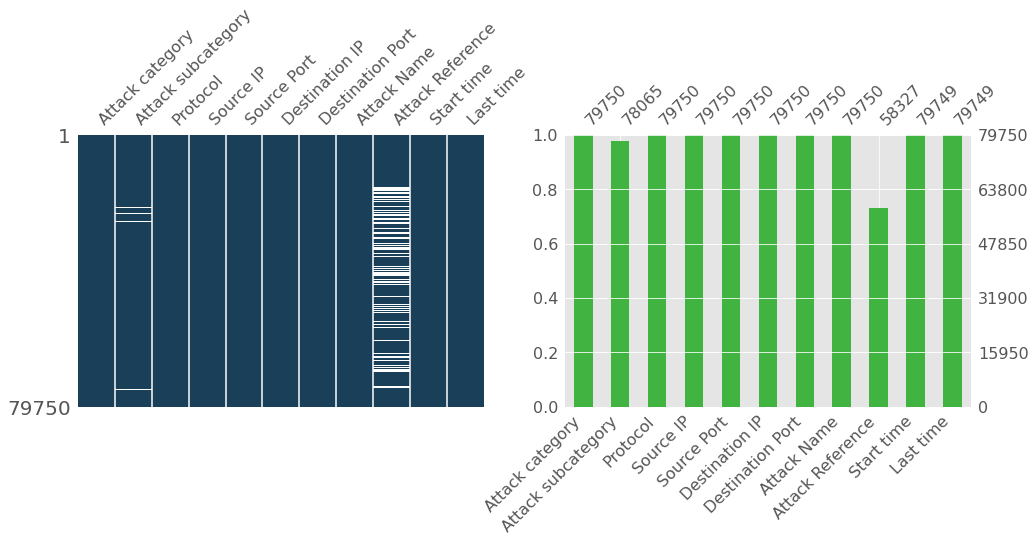

In [11]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
msno.matrix(df, ax=ax1, sparkline=False, color=(0.1, 0.25, 0.35))
msno.bar(df, ax=ax2, color=(0.25, 0.7, 0.25))
plt.show()

In [12]:
df.isnull().sum()

Attack category           0
Attack subcategory     1685
Protocol                  0
Source IP                 0
Source Port               0
Destination IP            0
Destination Port          0
Attack Name               0
Attack Reference      21423
Start time                1
Last time                 1
dtype: int64

In [13]:
df["Attack subcategory"] = df["Attack subcategory"].fillna("Not Registered")

In [14]:
df.isnull().sum()

Attack category           0
Attack subcategory        0
Protocol                  0
Source IP                 0
Source Port               0
Destination IP            0
Destination Port          0
Attack Name               0
Attack Reference      21423
Start time                1
Last time                 1
dtype: int64

In [15]:
df[pd.isnull(df).any(axis=1)].shape

(21423, 11)

In [16]:
df[df.duplicated()].shape

(3, 11)

In [17]:
print('Dimensions before dropping duplicated rows: ' + str(df.shape))
df = df.drop(df[df.duplicated()].index)
print('Dimensions after dropping duplicated rows: ' + str(df.shape))

Dimensions before dropping duplicated rows: (79750, 11)
Dimensions after dropping duplicated rows: (79747, 11)


In [18]:
df[df.duplicated()]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time


In [19]:
#port range 0 to 65535

In [20]:
invalid_SP = (df['Source Port'] < 0) | (df['Source Port'] > 65535)
invalid_DP = (df['Destination Port'] < 0) | (df['Destination Port'] > 65535)
df[invalid_SP | invalid_DP]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time


In [21]:
df = df[~(invalid_SP | invalid_DP)].reset_index(drop=True)


In [22]:
df.shape

(79747, 11)

In [23]:
print('Total number of different protocols:', len(df['Protocol'].unique()))
print('Total number of different Attack categories:', len(df['Attack category'].unique()))
df['Protocol'].unique()[:15]

Total number of different protocols: 131
Total number of different Attack categories: 13


array(['tcp', 'udp', 'Tcp', 'UDP', 'ospf', 'sctp', 'sep', 'mobile',
       'sun-nd', 'swipe', 'pim', 'ggp', 'ip', 'ipnip', 'st2'],
      dtype=object)

In [24]:
df['Attack category'].unique()

array(['Reconnaissance', 'Exploits', 'DoS', 'Generic', 'Shellcode',
       ' Fuzzers', 'Worms', 'Backdoors', 'Analysis', ' Fuzzers ',
       ' Reconnaissance ', 'Backdoor', ' Shellcode '], dtype=object)

In [25]:
df['Protocol'] = df['Protocol'].str.upper().str.strip()
df['Attack category'] = df['Attack category'].str.upper().str.strip()
df['Attack category'] = df['Attack category'].str.strip().replace('BACKDOORS','BACKDOOR')

df

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,1421927414,1421927416
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,1421927415,1421927415
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,1421927416,1421927416
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,1421927417,1421927417
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,1421927418,1421927418
...,...,...,...,...,...,...,...,...,...,...,...
79742,EXPLOITS,Web Application,SPRITE-RPC,175.45.176.1,0,149.171.126.10,0,SkyBlueCanvas CMS Un-Authenticated Command Exe...,CVE 2014-1683 (http://cve.mitre.org/cgi-bin/cv...,1424237336,1424237336
79743,GENERIC,IXIA,LARP,175.45.176.1,0,149.171.126.10,0,Linux_Kernel_NetFilter_SCTP_Unknown_Chunk_Type...,CVE 2007-2876 (http://cve.mitre.org/cgi-bin/cv...,1424237336,1424237336
79744,GENERIC,IXIA,SPRITE-RPC,175.45.176.1,0,149.171.126.10,0,Linux_Kernel_NetFilter_SCTP_Unknown_Chunk_Type...,CVE 2007-2876 (http://cve.mitre.org/cgi-bin/cv...,1424237336,1424237336
79745,FUZZERS,HTTP,TCP,175.45.176.1,35826,149.171.126.11,80,Fuzzer: HTTP GET Request Invalid URI (Encoded)...,NaN,1424237336,1424237337


In [26]:
print('Total number of different protocols:', len(df['Protocol'].unique()))
print('Total number of different Attack categories:', len(df['Attack category'].unique()))

Total number of different protocols: 129
Total number of different Attack categories: 9


In [27]:
df[pd.isnull(df['Attack Reference'])].shape

(21423, 11)

In [28]:
print(df[pd.isnull(df['Attack Reference'])]['Attack category'].value_counts())

FUZZERS           12814
RECONNAISSANCE     7483
ANALYSIS            633
SHELLCODE           305
GENERIC             138
BACKDOOR             22
DOS                  22
WORMS                 4
EXPLOITS              2
Name: Attack category, dtype: int64


In [29]:
print(df['Attack category'].value_counts())

EXPLOITS          31585
FUZZERS           16803
DOS                9898
RECONNAISSANCE     9319
GENERIC            8480
BACKDOOR           1941
ANALYSIS            893
SHELLCODE           744
WORMS                84
Name: Attack category, dtype: int64


In [30]:
# Percentage of missing values in 'Attack Reference' per Attack Category
((df[pd.isnull(df['Attack Reference'])]['Attack category'].value_counts()/df['Attack category'].value_counts())*100).dropna().sort_values(ascending=False)

RECONNAISSANCE    80.298315
FUZZERS           76.260192
ANALYSIS          70.884658
SHELLCODE         40.994624
WORMS              4.761905
GENERIC            1.627358
BACKDOOR           1.133436
DOS                0.222267
EXPLOITS           0.006332
Name: Attack category, dtype: float64

In [31]:
tcp_ports = pd.read_csv('TCP-ports.csv')
tcp_ports['Service'] = tcp_ports['Service'].str.upper()
tcp_ports.head()

,Port,Service,Description
0,0,NaN,Reserved
1,1,TCPMUX,TCP Port Service Multiplexer
2,2,COMPRESSNET,Management Utility
3,3,COMPRESSNET,Compression Process
4,5,RJE,Remote Job Entry


In [32]:
print('Dimensions before merging dataframes: ' ,(df.shape))

newdf = pd.merge(df, tcp_ports[['Port','Service']], left_on='Destination Port', right_on='Port', how='left')
newdf = newdf.rename(columns={'Service':'Destination Port Service'})

print('Dimensions after merging dataframes: ' + str(newdf.shape))

Dimensions before merging dataframes:  (79747, 11)
Dimensions after merging dataframes: (79747, 13)


In [33]:
newdf = newdf.drop(columns=['Port'])
newdf.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,1421927414,1421927416,HTTP
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,1421927415,1421927415,NaN
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,1421927416,1421927416,HTTP
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,1421927417,1421927417,PERSONAL-AGENT
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,1421927418,1421927418,HTTP


In [34]:
newdf['Attack category'].unique()

array(['RECONNAISSANCE', 'EXPLOITS', 'DOS', 'GENERIC', 'SHELLCODE',
       'FUZZERS', 'WORMS', 'BACKDOOR', 'ANALYSIS'], dtype=object)

In [35]:
newdf['Attack category'].value_counts()

EXPLOITS          31585
FUZZERS           16803
DOS                9898
RECONNAISSANCE     9319
GENERIC            8480
BACKDOOR           1941
ANALYSIS            893
SHELLCODE           744
WORMS                84
Name: Attack category, dtype: int64

In [36]:
newdf['Attack category'].value_counts()*100/newdf['Attack category'].value_counts().sum()

EXPLOITS          39.606506
FUZZERS           21.070385
DOS               12.411752
RECONNAISSANCE    11.685706
GENERIC           10.633629
BACKDOOR           2.433947
ANALYSIS           1.119791
SHELLCODE          0.932950
WORMS              0.105333
Name: Attack category, dtype: float64

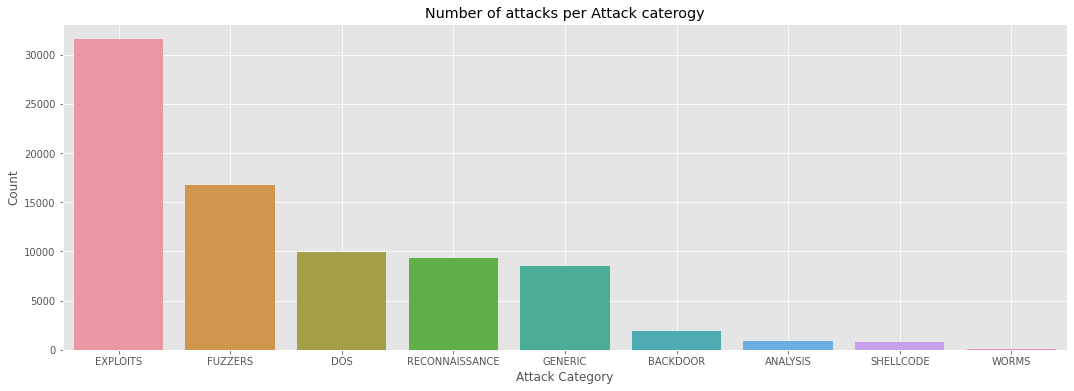

In [37]:
plt.figure(figsize=(18,6))
sns.barplot(x=newdf['Attack category'].value_counts().index,y=newdf['Attack category'].value_counts())
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.title('Number of attacks per Attack caterogy')
plt.grid(True)

In [38]:
pd.DataFrame(newdf['Attack category'].value_counts())[:]

,Attack category
EXPLOITS,31585
FUZZERS,16803
DOS,9898
RECONNAISSANCE,9319
GENERIC,8480
BACKDOOR,1941
ANALYSIS,893
SHELLCODE,744
WORMS,84


In [39]:
a=pd.DataFrame(newdf['Attack category'].value_counts())[:6]

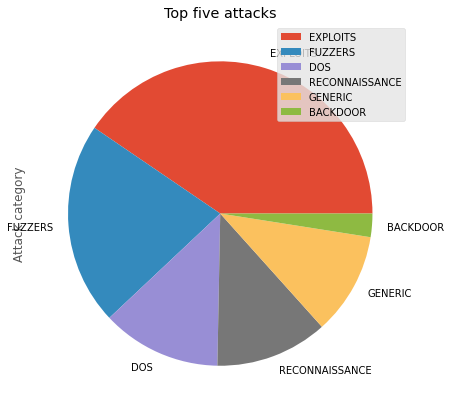

In [40]:
a.plot(kind='pie', subplots=True, figsize=(7, 7))
plt.title('Top five attacks')
plt.legend(loc='left')
plt.show()

# NOW TO ANALYSE Attacks WITH DATE AND TIME

In [43]:
newdf['Start time']

0       2015-01-22 11:50:14
1       2015-01-22 11:50:15
2       2015-01-22 11:50:16
3       2015-01-22 11:50:17
4       2015-01-22 11:50:18
                ...        
79742   2015-02-18 05:28:56
79743   2015-02-18 05:28:56
79744   2015-02-18 05:28:56
79745   2015-02-18 05:28:56
79746                   NaT
Name: Start time, Length: 79747, dtype: datetime64[ns]

In [47]:
newdf['Start time'] = pd.to_datetime(newdf['Start time'], unit='s')
newdf['Last time'] = pd.to_datetime(newdf['Last time'], unit='s')
newdf['Duration'] = ((newdf['Last time'] - newdf['Start time']).dt.seconds).astype(int)

In [48]:
newdf[:5]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Duration
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,2015-01-22 11:50:14,2015-01-22 11:50:16,2
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:15,2015-01-22 11:50:15,0
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:16,2015-01-22 11:50:16,0
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:17,2015-01-22 11:50:17,0
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:18,2015-01-22 11:50:18,0


In [49]:
newdf['Start time'].astype(str).str.split(' ').str[0].unique()

array(['2015-01-22', '2015-02-18', '1970-01-01'], dtype=object)

we are going to execute from now on is based on information related to two days, 
Thursday - January 22nd/2015, and on Wednesday - February 18th/2015.

In [50]:
newdf.describe()

,Source Port,Destination Port,Duration
count,79747.000000,79747.000000,79747.000000
mean,16409.199343,1391.476519,1.800093
std,22008.543817,7695.200135,7.782157
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1043.000000,21.000000,0.000000
75%,34618.000000,110.000000,1.000000
max,65535.000000,65535.000000,60.000000


Mean and 75% percentile is very different for SOurcePOrt and Destination Port is very different.
However minimum and maximum is same. Here comes the Hypothesis testing.


$$ H_0: \mu_1=\mu_2$$
$$ H_a: \mu_1\neq\mu_2$$

We can obtain one of two results from the test:

1. If the **$p$-value** is less than our significance level ($p<\alpha$) we reject the null hypothesis $H_0$ and affirm that the observed difference is **statistically significant**.
2. If the **$p$-value** is greater than our significance level ($p>\alpha$) we will have to retain $H_0$ and conclude that the observed difference **is not statistically significant**.

The hypothesis test is conducted using a statistical **$T-test$** which specifies the two Series `df_interest['Source Port']` and `df_interest['Destination Port']`. By specifying these two Series, we are automatically referring to a comparative test of the means of both Series:

In [51]:
statistic, pvalue = stats.ttest_ind( newdf['Source Port'], newdf['Destination Port'], equal_var=False)
print('p-value in T-test: ' + str(pvalue))

p-value in T-test: 0.0


Because the $p$-value is very close to zero, Python approximates this measurement to 0.0. With this in mind, we can reject the null hypothesis $H_0$ regarding the equality of the means of the source and destination ports. This means that the source port of the attacks is very different from the destination port. In this way, most attacks are directed at specific logical ports, which does not leave a random spot

We will be using two methods for correlation calculation:
•Pearson's correlation: evaluates the linear relationships between two variables. If the value is close to 0, there is a weak or nonexistent linear relationship between the variables.
•Spearman's correlation: evaluates the monotonic relationships between two variables. If the value is close to 0, there is a weak or nonexistent monotonic relationship between the variables.


In [52]:
newdf.corr(method='pearson')

,Source Port,Destination Port,Duration
Source Port,1.000000,0.136118,-0.051267
Destination Port,0.136118,1.000000,-0.022111
Duration,-0.051267,-0.022111,1.000000


In [53]:
newdf.corr(method='spearman')

,Source Port,Destination Port,Duration
Source Port,1.000000,0.864697,0.380688
Destination Port,0.864697,1.000000,0.358978
Duration,0.380688,0.358978,1.000000


In [54]:
df_dummies = pd.get_dummies(newdf, columns=['Attack category'])

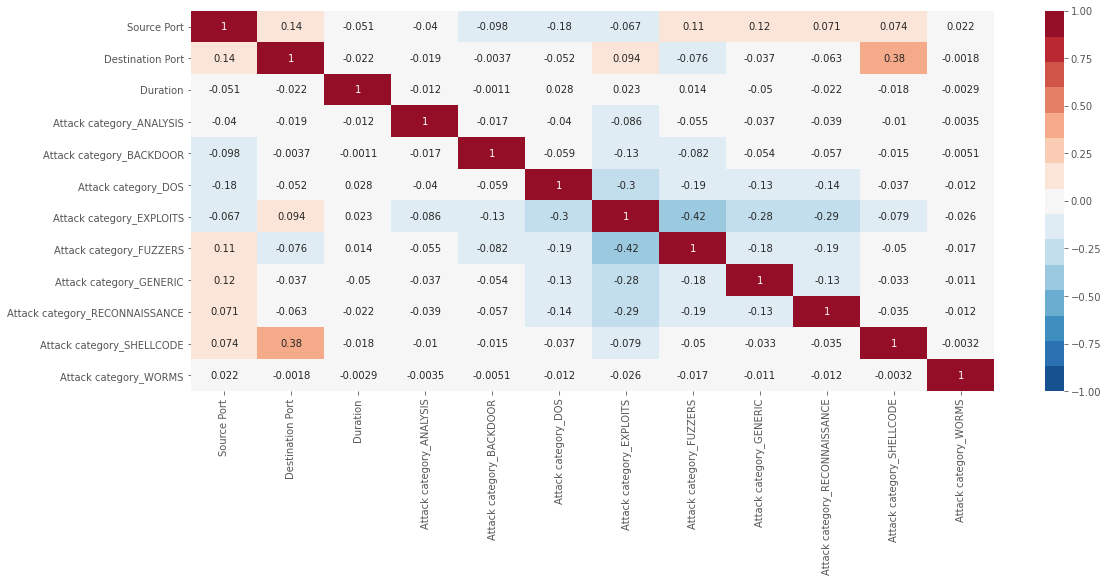

In [55]:
plt.figure(figsize=(18,7))
sns.heatmap(df_dummies.corr(method='pearson'), 
            annot=True, vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 15))
plt.show()

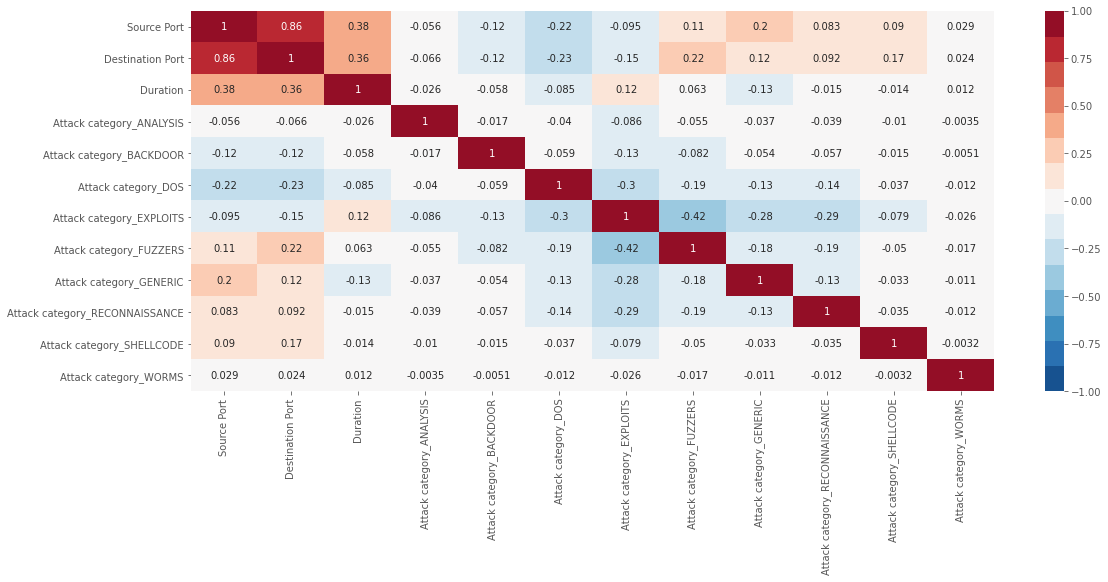

In [56]:
plt.figure(figsize=(18,7))
sns.heatmap(df_dummies.corr(method='spearman'), 
            annot=True, vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 15))
plt.show()


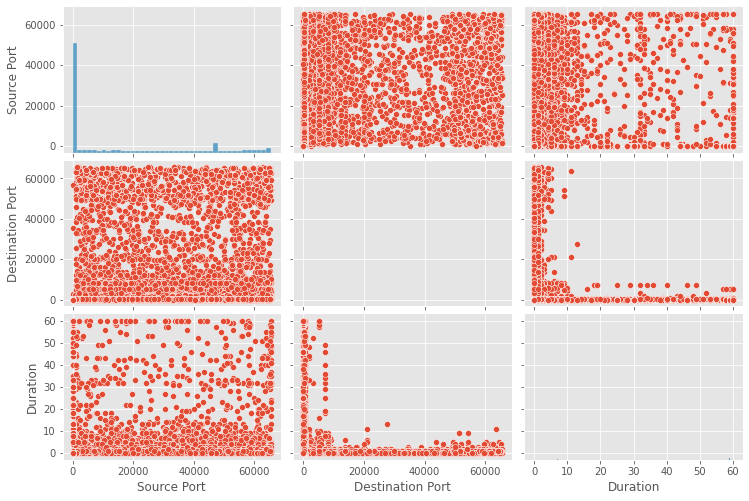

In [57]:
g = sns.pairplot(newdf)
g.fig.set_size_inches(11,7)
plt.show()

In [58]:
newdf['Destination IP'].value_counts()[:5]

149.171.126.19    17807
149.171.126.13    16381
149.171.126.10     9909
149.171.126.18     7504
149.171.126.12     7334
Name: Destination IP, dtype: int64

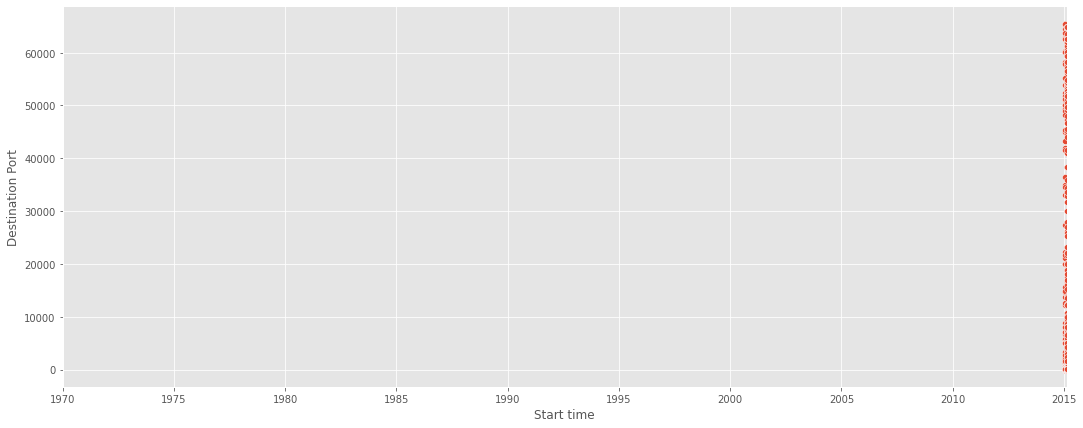

In [59]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=newdf['Start time'].min()-timedelta(days=1),right=newdf['Start time'].max()+timedelta(days=1))
plt.grid(True)
plt.show()

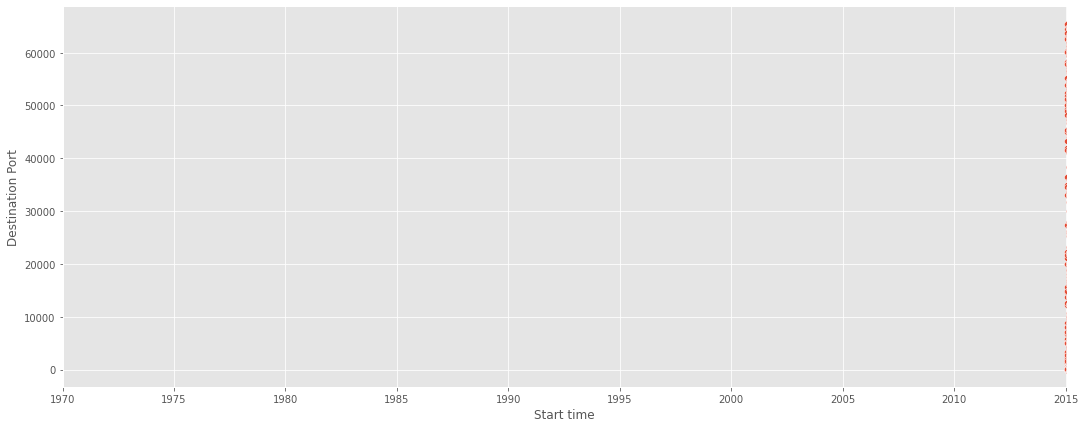

In [60]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=newdf['Start time'].min(),right=datetime.strptime('15-01-23', '%y-%m-%d'))
plt.grid(True)
plt.show()


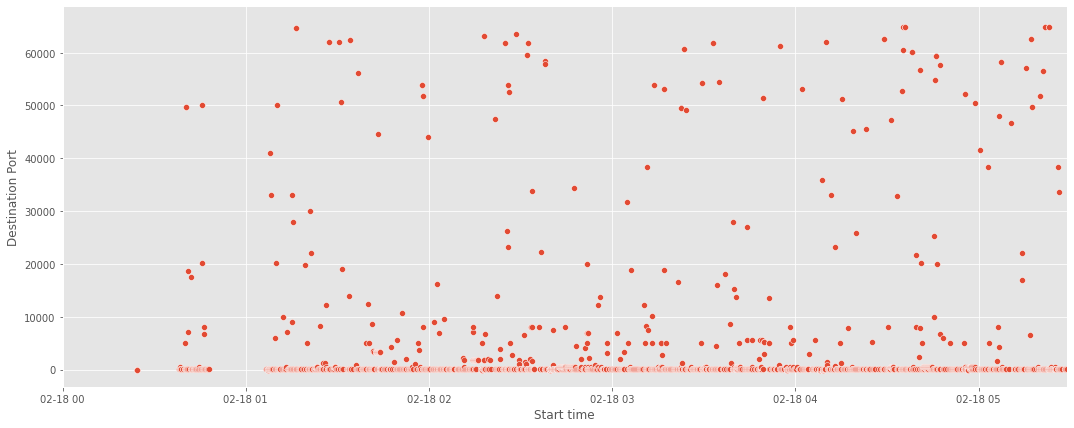

In [61]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=datetime.strptime('15-02-18', '%y-%m-%d'),right=newdf['Start time'].max())
plt.grid(True)
plt.show()

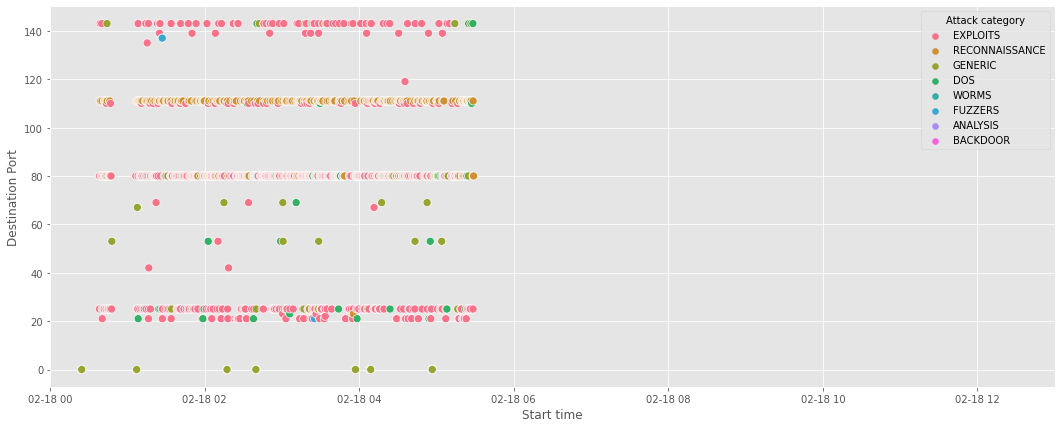

In [62]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Start time', y='Destination Port', hue='Attack category', 
                data=newdf[(newdf['Destination IP']=='149.171.126.17')&(newdf['Destination Port']<=150)], 
                s=65)
plt.xlim(left=datetime.strptime('15-02-18 00:00:00', '%y-%m-%d %H:%M:%S'),
         right=datetime.strptime('15-02-18 13:00:00', '%y-%m-%d %H:%M:%S'))
plt.grid(True)
plt.show()

# Duration vs Destination Ports

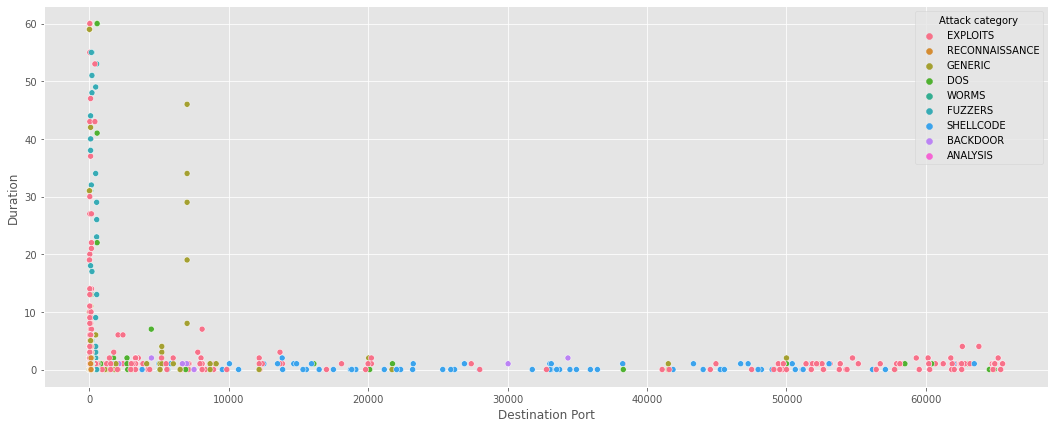

In [63]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Destination Port', y='Duration', hue='Attack category', data=newdf[newdf['Destination IP']=='149.171.126.17'])
plt.grid(True)
plt.show()

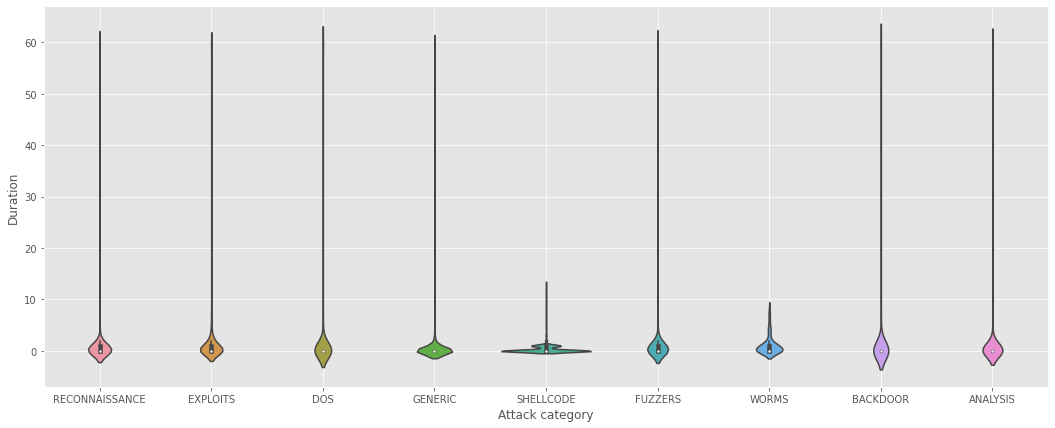

In [64]:
plt.figure(figsize=(18,7))
sns.violinplot(x='Attack category', y='Duration', data=newdf)
plt.grid(True)
plt.show()

In [65]:
def heatmap_graph(df, xlabel, ylabel, title):
    plt.figure(figsize=(18,8))
    ax = sns.heatmap(df)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

In [66]:
newdf["Start time"][1].hour

11

In [67]:
df_pivot = newdf.copy()
df_pivot['hour'] = df_pivot.apply(lambda row: '0'*(2-len(str(row['Start time'].hour)))+str(row['Start time'].hour)+':00:00', axis=1)

In [68]:
df_pivot[:5]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Duration,hour
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,2015-01-22 11:50:14,2015-01-22 11:50:16,2,11:00:00
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:15,2015-01-22 11:50:15,0,11:00:00
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:16,2015-01-22 11:50:16,0,11:00:00
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:17,2015-01-22 11:50:17,0,11:00:00
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:18,2015-01-22 11:50:18,0,11:00:00


In [69]:
df_p1 = pd.pivot_table(df_pivot,values='Attack Name', index=['hour'], columns=['Attack category'], aggfunc='count')
df_p1

Attack category,ANALYSIS,BACKDOOR,DOS,EXPLOITS,FUZZERS,GENERIC,RECONNAISSANCE,SHELLCODE,WORMS
hour,,,,,,,,,
00:00:00,3.0,16.0,127.0,543.0,392.0,60.0,177.0,20.0,3.0
01:00:00,186.0,1148.0,2640.0,6716.0,4477.0,1748.0,1804.0,105.0,14.0
02:00:00,71.0,100.0,630.0,2861.0,1983.0,1031.0,1023.0,113.0,10.0
03:00:00,226.0,60.0,3755.0,9759.0,2743.0,1513.0,2727.0,113.0,17.0
04:00:00,64.0,87.0,617.0,2776.0,2090.0,1349.0,1034.0,115.0,10.0
05:00:00,85.0,274.0,1321.0,4144.0,983.0,237.0,810.0,55.0,6.0
11:00:00,NaN,NaN,48.0,366.0,495.0,43.0,140.0,20.0,3.0
12:00:00,199.0,230.0,532.0,2714.0,2324.0,894.0,882.0,115.0,15.0
13:00:00,59.0,26.0,228.0,1706.0,1316.0,1605.0,722.0,88.0,6.0


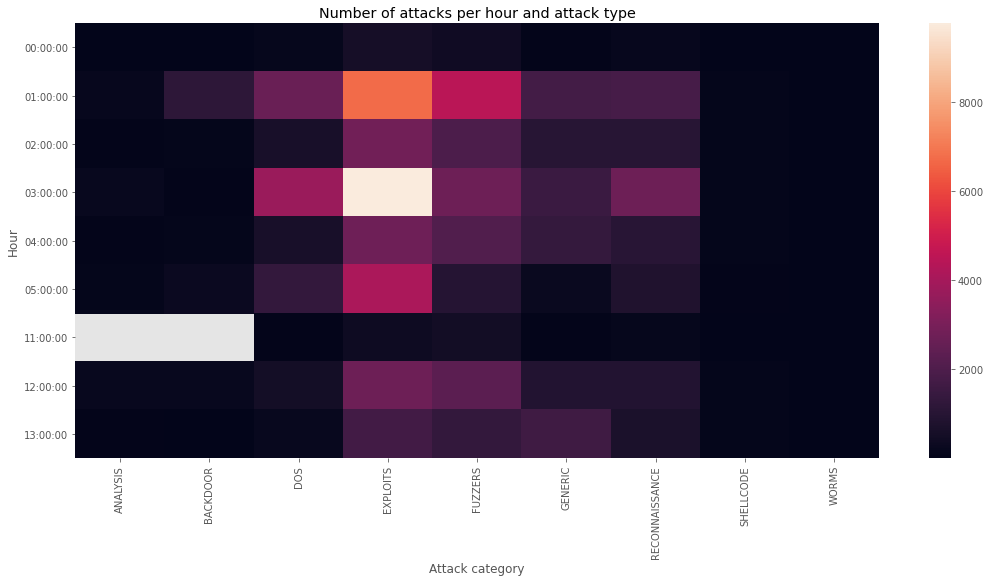

In [70]:
heatmap_graph(df = df_p1, xlabel = 'Attack category', ylabel = 'Hour', title = 'Number of attacks per hour and attack type')

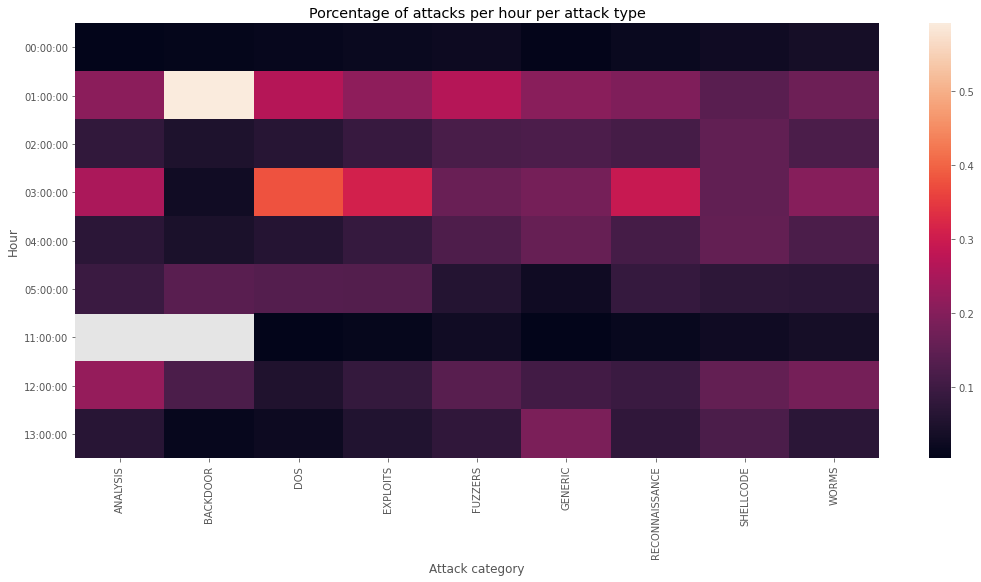

In [71]:
heatmap_graph(df = df_p1/df_p1.sum(), xlabel = 'Attack category', ylabel = 'Hour', title = 'Porcentage of attacks per hour per attack type')

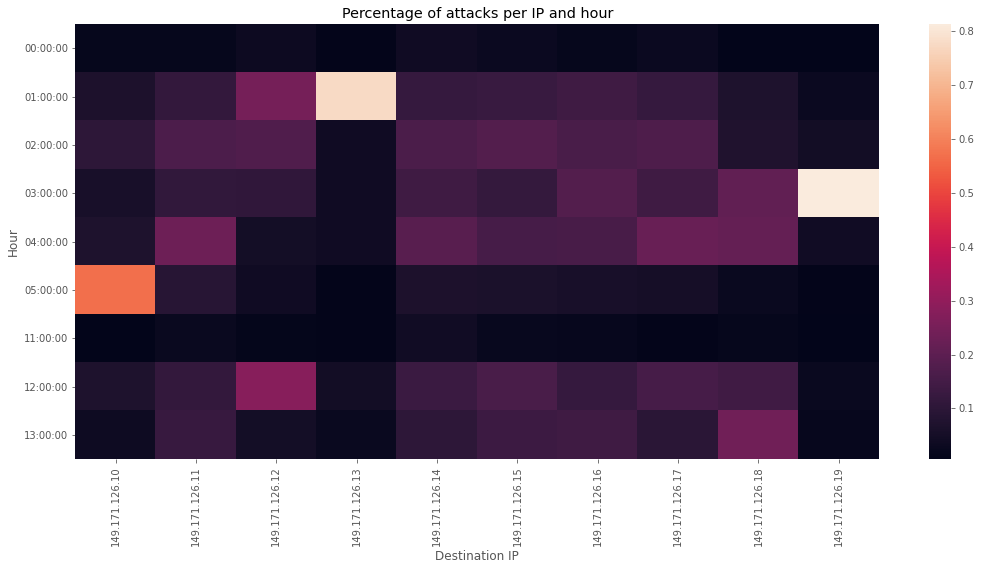

In [72]:
df_p2 = pd.pivot_table(df_pivot, values='Attack Name', index=['hour'], columns=['Destination IP'], aggfunc='count')
heatmap_graph(df = df_p2/df_p2.sum(), xlabel = 'Destination IP', ylabel = 'Hour', title = 'Percentage of attacks per IP and hour')

Although there are more than 170,000 records related to cybersecurity attacks, these attacks target 10 servers with IPv4 addresses in the interval  [149.171.126.10,149.171.126.19] . This means that the company was attacked on multiple occasions during the observed timeframe, on a specific subnet, which denotes a non-accidental and directed succession of events.

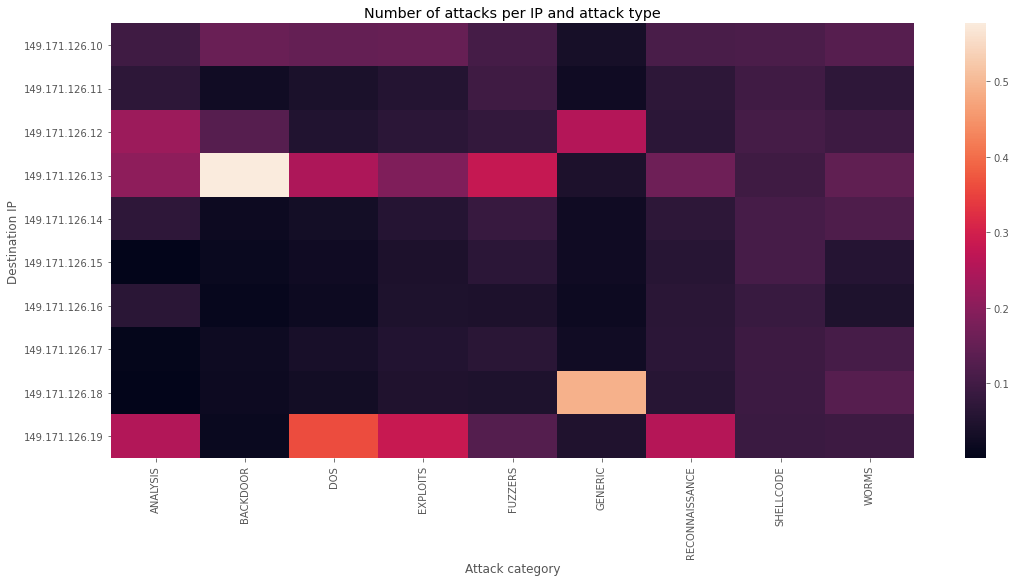

In [73]:
df_p3 = pd.pivot_table(df_pivot, values='Attack Name', index=['Destination IP'], columns=['Attack category'], aggfunc='count')
heatmap_graph(df = df_p3/df_p3.sum(), xlabel = 'Attack category', ylabel = 'Destination IP', title = 'Number of attacks per IP and attack type')

In [ ]:
The most attacked machine is the one with the IPv4 address 149.171.126.17. Conversely, while worms, shellcode and generic attacks are not directed at particular machines, Denial of Services, Exploits and Backdoor attacks are clearly targeted towards specific servers.

Let's now look at this same relationship per attack category performing a pair-wise **$T-test$**:

In [75]:
for attack in list(newdf['Attack category'].unique()):
    df_attack = newdf[newdf['Attack category'] == attack].copy()
    statistic, pvalue = stats.ttest_ind(df_attack['Source Port'], df_attack['Destination Port'], equal_var=False)
    print('p-value in T-test for ' + attack + ' attack: ' + str(pvalue))

p-value in T-test for RECONNAISSANCE attack: 0.0
p-value in T-test for EXPLOITS attack: 0.0
p-value in T-test for DOS attack: 1.9319300977251127e-279
p-value in T-test for GENERIC attack: 0.0
p-value in T-test for SHELLCODE attack: 0.11826498865248351
p-value in T-test for FUZZERS attack: 0.0
p-value in T-test for WORMS attack: 3.617249549563666e-23
p-value in T-test for BACKDOOR attack: 4.7625894276961846e-08
p-value in T-test for ANALYSIS attack: 2.1422863889200094e-35


As can be seen, the 𝑝-values of all but one attack category are very close to 0.0. This means that the attacks have been directed to the specific ports, except for the Shellcode attacks, whose null hypothesis cannot be rejected. For this type of attack there is a defined randomness, which means that the source and destination ports have similar averages.

To verify this statement, we will make use of a contingency table which allows to relate the count of a certain pair of variables, similar to how we saw the .pivot_table()

In [76]:
df_crosstab = pd.crosstab(newdf['Attack category'], newdf['Destination Port'])
df_crosstab

Destination Port,0,10,21,22,23,25,31,42,53,67,68,69,80,81,88,89,105,110,111,119,123,135,137,138,139,143,161,162,179,383,389,443,445,446,464,465,497,500,502,513,...,64887,64906,64913,64944,64961,64967,65002,65007,65036,65043,65053,65054,65080,65097,65120,65127,65176,65185,65198,65218,65239,65245,65248,65262,65287,65300,65306,65334,65359,65361,65365,65390,65398,65419,65420,65446,65497,65502,65511,65535
Attack category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ANALYSIS,713,0,0,0,0,2,0,0,0,0,0,0,178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BACKDOOR,1776,0,4,0,0,0,3,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DOS,8047,4,37,0,7,206,0,0,72,15,0,15,872,0,17,0,0,47,4,0,9,4,0,3,24,52,6,11,0,0,20,12,43,0,3,1,0,6,11,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
EXPLOITS,17721,0,1078,6,68,2230,0,11,84,43,0,40,5724,3,0,4,0,807,44,11,0,10,5,6,125,783,4,0,2,7,37,38,83,3,0,0,0,0,0,25,...,2,2,0,2,2,2,0,0,2,2,2,2,2,2,4,2,0,2,2,2,0,2,2,0,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,0
FUZZERS,6638,0,419,0,0,0,0,0,0,0,0,93,650,0,0,0,0,0,0,0,0,319,156,0,0,0,0,0,3031,0,0,0,2315,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GENERIC,696,0,12,3,0,212,0,0,5923,27,1,71,799,0,0,0,4,17,6,4,0,0,0,0,0,87,0,3,0,0,15,16,16,0,0,0,6,20,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
RECONNAISSANCE,3515,0,0,0,3,4,0,0,21,0,0,0,1054,0,0,0,0,0,4675,0,0,0,3,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SHELLCODE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
WORMS,0,0,0,0,0,0,0,0,0,0,0,3,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


contingency table of `Attack type` versus `Target port` and the individual counts are not uniform. This allows to affirm our inference that there might be an interaction between these two variables. We can formally test whether the variations we observe reflect real differences or are just a by-product of randomness. There are many different ways to test, but we will focus on the most widely used test: the **Chi-square test**. The null hypothesis for the Chi-square test is as follows:

$$
H_0:\text {The attack category is independent of the destination port}
$$

Intuitively, *"independence between two variables"* means that the distribution of values of one variable remains the same even when the value of the second variable changes (and vice versa). In our case, this means that the proportions of the different attack categories remain the same, even when we look at different destination ports. The data seems to indicate otherwise, so let's discuss how to numerically summarize the data to formally examine the null hypothesis:

In [77]:
chi2, p_value, dof, expected = chi2_contingency(df_crosstab)
print("p-value of Chi-square test for Attack category vs. Destination Port =", p_value)

p-value of Chi-square test for Attack category vs. Destination Port = 0.0


The  𝑝 -value is extremely small and therefore we reject the null hypothesis and conclude that the attack category and destination port are not independent. In other words, the destination port do not remain the same for different attack categories, what agrees with what we observe previously.

To visualize this relationship between these variables (`source port`, `destination port`, and `attack category`), we can initially make a scatterplot using the `.scatterplot()` function between the source and destination ports in terms of the attack category:

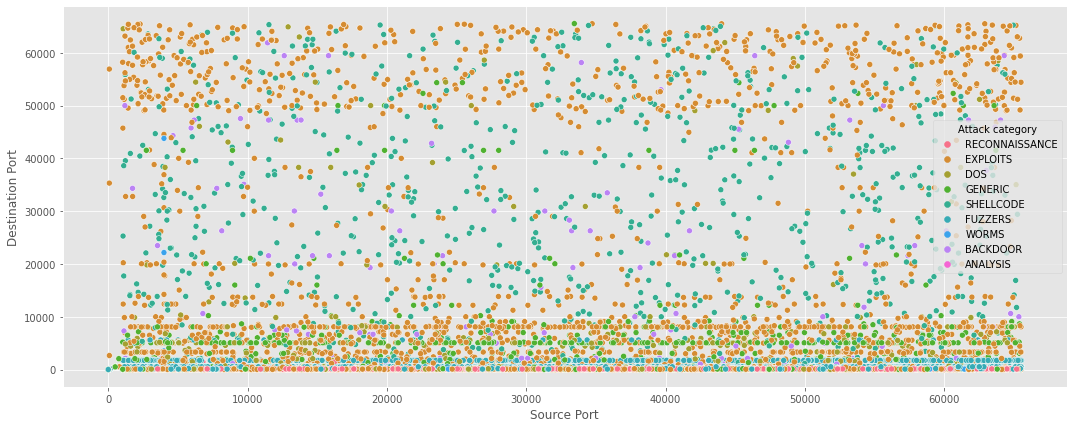

In [78]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Source Port',y='Destination Port', hue='Attack category',data=newdf)
plt.show()

A certain pattern can be seen in the graph, in which attacks usually occur on ports less than 10,000 or greater than 50,000, except for shellcode-type attacks, as we had anticipated in the hypothesis test.

To see this relationship more in depth, we can visualize the the distribution of the logical origin and destination ports with a strip diagram using the `.stripplot()` function:

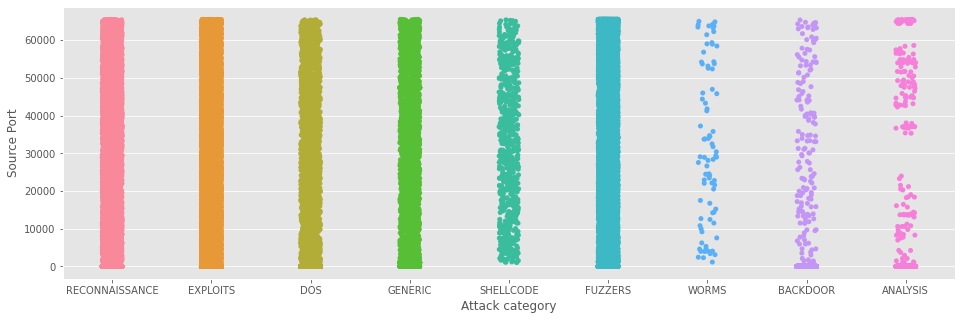

In [79]:
# Source ports
plt.figure(figsize=(16,5))
sns.stripplot(x='Attack category',y='Source Port',data=newdf)
plt.show()


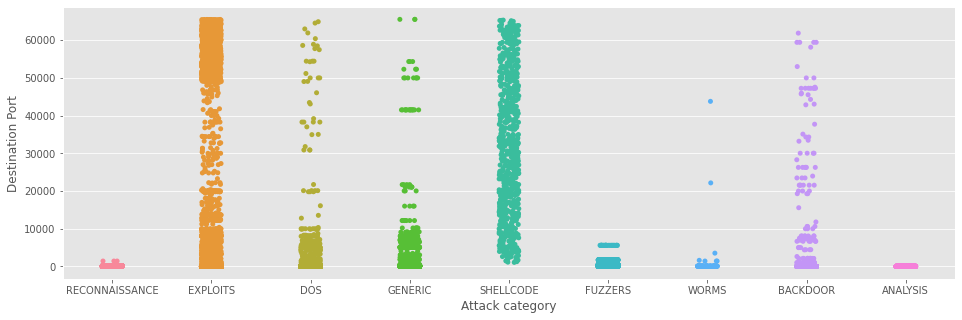

In [80]:

# Destination ports
plt.figure(figsize=(16,5))
sns.stripplot(x='Attack category',y='Destination Port',data=newdf)
plt.show()

In [81]:
list(newdf['Source IP'].unique())

['175.45.176.0', '175.45.176.3', '175.45.176.2', '175.45.176.1']

view of the distribution of destination ports by attack category and source IP:

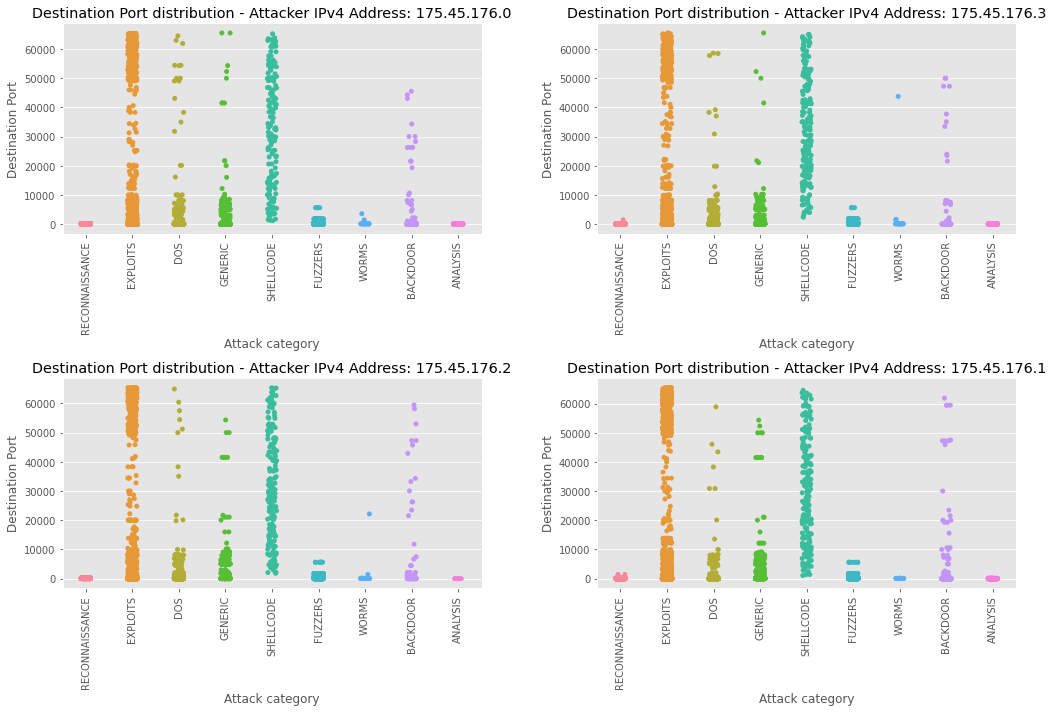

In [82]:
ips = list(newdf['Source IP'].unique())
f, axes = plt.subplots(2, 2)
f.set_figheight(10)
f.set_figwidth(15)

labels = list(newdf['Attack category'].unique())
for i, ip in enumerate(ips):
    sns.stripplot(x='Attack category',y='Destination Port',data=newdf[newdf['Source IP'] == ip], order=labels, ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_xlabel('Attack category')
    axes[int(i/2)][i%2].set_ylabel('Destination Port')
    axes[int(i/2)][i%2].set_title('Destination Port distribution - Attacker IPv4 Address: ' + ip)
    axes[int(i/2)][i%2].set_xticklabels(labels,rotation=90)
plt.tight_layout()
plt.show()

 view of the distribution of destination ports by attack category and destination IP:

In [83]:
list(newdf['Destination IP'].unique())


['149.171.126.16',
 '149.171.126.18',
 '149.171.126.10',
 '149.171.126.15',
 '149.171.126.14',
 '149.171.126.12',
 '149.171.126.13',
 '149.171.126.11',
 '149.171.126.17',
 '149.171.126.19']

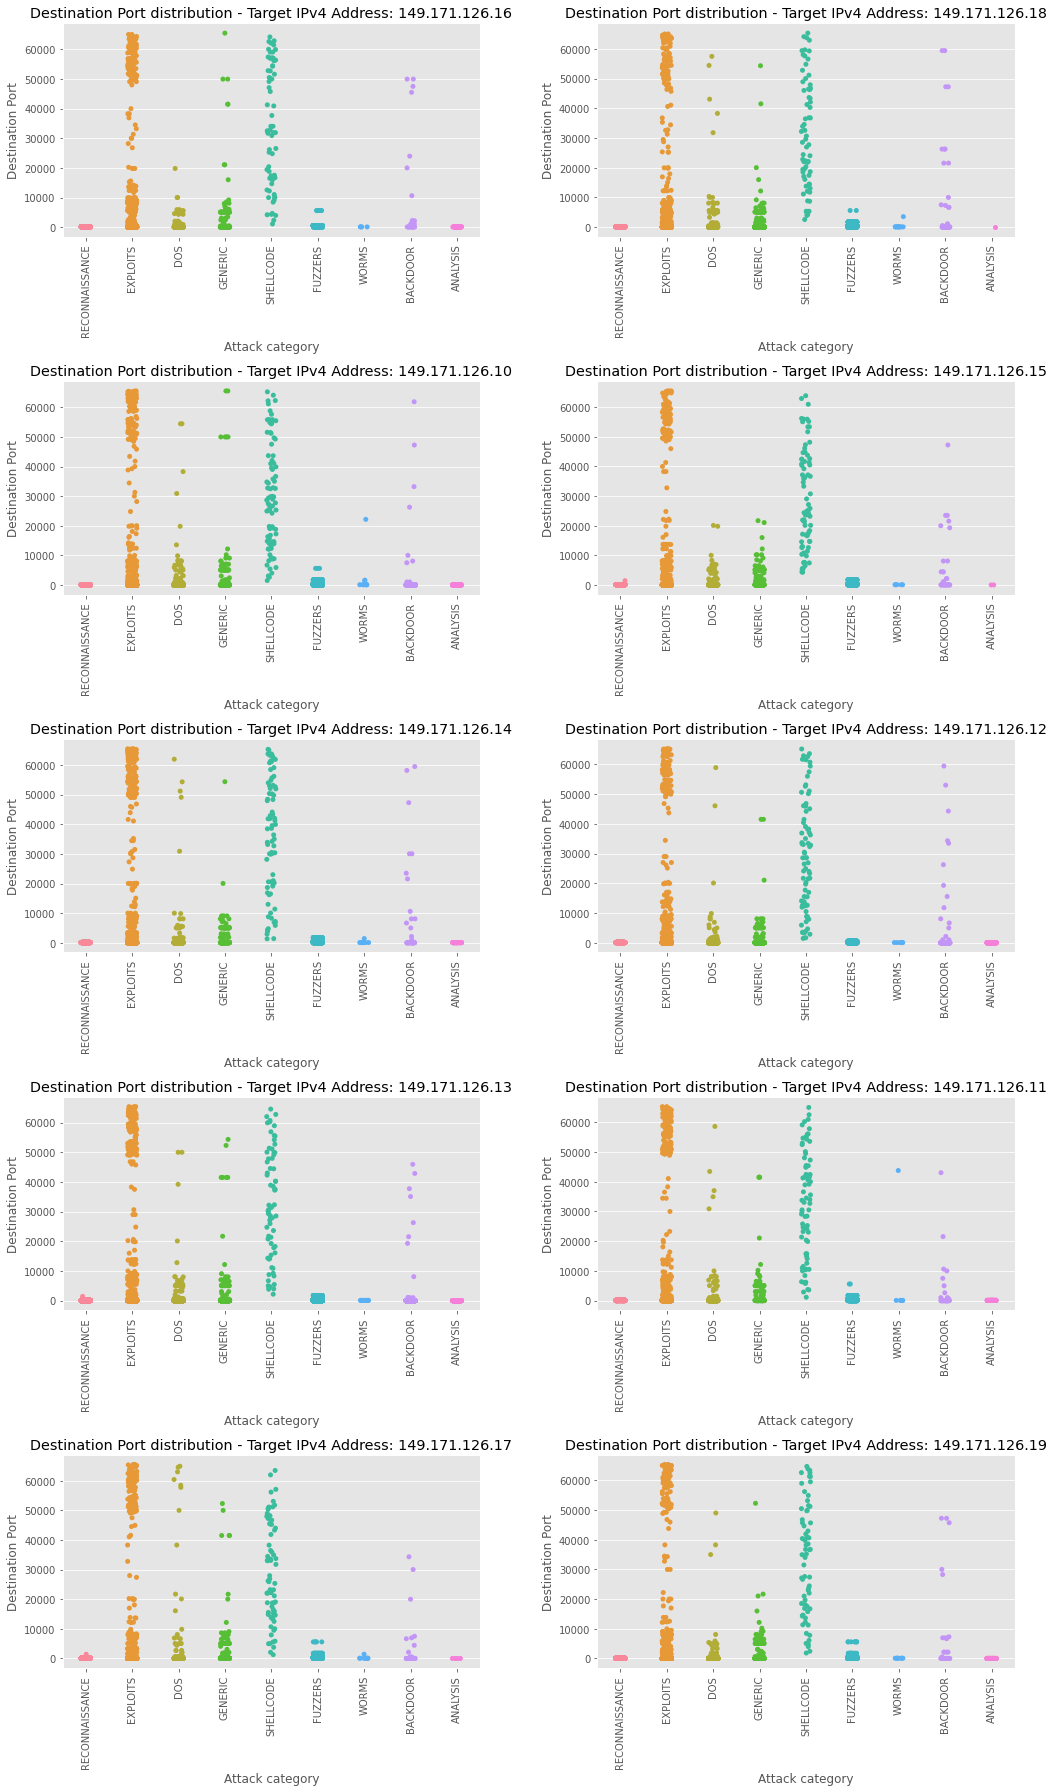

In [84]:
ips = list(newdf['Destination IP'].unique())
f, axes = plt.subplots(5, 2)
f.set_figheight(25)
f.set_figwidth(15)

labels = list(newdf['Attack category'].unique())

for i, ip in enumerate(ips):
    sns.stripplot(x='Attack category',y='Destination Port',data=newdf[newdf['Destination IP'] == ip], order=labels, ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_xlabel('Attack category')
    axes[int(i/2)][i%2].set_ylabel('Destination Port')
    axes[int(i/2)][i%2].set_title('Destination Port distribution - Target IPv4 Address: ' + ip)
    axes[int(i/2)][i%2].set_xticklabels(labels,rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
These graphs show us that there is a differentiation in the way in which the attacks are performing their tasks. There is a particularization by the targets, something that does not happen with the source devices.